In [1]:
import sys
from tqdm import tqdm
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from data.energy_data import EnergyDataset
from models.lstm import LSTM

In [2]:
timeseries = pd.read_csv('../data/data_preprocessed.csv')
timeseries = timeseries[['_value']]

In [14]:
train_dataset = EnergyDataset('../data/train.csv', window_size=4)
test_dataset = EnergyDataset('../data/test.csv', window_size=4)

train_loader = DataLoader(train_dataset, batch_size=4, drop_last=True, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, drop_last=True, shuffle=False)

X_train, y_train = train_dataset.return_X_y()
X_test, y_test = test_dataset.return_X_y()

In [15]:
model = LSTM(input_size=1, hidden_size=50, num_layers=1, output_size=1)
optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss()

In [16]:
n_epochs = 100

train_progress = []
test_progress = []

for i in range(n_epochs):
    model.train()
    for x_batch, y_batch in tqdm(train_loader):
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # if i % 10 == 0:
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train)
        y_pred_test = model(X_test)
        train_rmse = np.sqrt(loss_function(y_pred_train, y_train).item())
        test_rmse = np.sqrt(loss_function(y_pred_test, y_test).item())
        train_progress.append(train_rmse)
        test_progress.append(test_rmse)
        
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (i, train_rmse, test_rmse))


100%|██████████| 6800/6800 [00:09<00:00, 683.20it/s]


Epoch 0: train RMSE 0.1297, test RMSE 0.0816


100%|██████████| 6800/6800 [00:09<00:00, 689.46it/s]


Epoch 1: train RMSE 0.1260, test RMSE 0.0801


100%|██████████| 6800/6800 [00:09<00:00, 687.88it/s]


Epoch 2: train RMSE 0.1251, test RMSE 0.0803


100%|██████████| 6800/6800 [00:09<00:00, 703.18it/s]


Epoch 3: train RMSE 0.1244, test RMSE 0.0801


100%|██████████| 6800/6800 [00:09<00:00, 702.10it/s]


Epoch 4: train RMSE 0.1244, test RMSE 0.0771


100%|██████████| 6800/6800 [00:09<00:00, 686.84it/s]


Epoch 5: train RMSE 0.1229, test RMSE 0.0779


100%|██████████| 6800/6800 [00:09<00:00, 687.78it/s]


Epoch 6: train RMSE 0.1226, test RMSE 0.0793


100%|██████████| 6800/6800 [00:09<00:00, 683.42it/s]


Epoch 7: train RMSE 0.1227, test RMSE 0.0774


100%|██████████| 6800/6800 [00:09<00:00, 691.99it/s]


Epoch 8: train RMSE 0.1213, test RMSE 0.0780


100%|██████████| 6800/6800 [00:09<00:00, 702.65it/s]


Epoch 9: train RMSE 0.1210, test RMSE 0.0788


100%|██████████| 6800/6800 [00:09<00:00, 685.87it/s]


Epoch 10: train RMSE 0.1211, test RMSE 0.0765


100%|██████████| 6800/6800 [00:10<00:00, 677.74it/s]


Epoch 11: train RMSE 0.1205, test RMSE 0.0782


100%|██████████| 6800/6800 [00:10<00:00, 654.54it/s]


Epoch 12: train RMSE 0.1210, test RMSE 0.0780


100%|██████████| 6800/6800 [00:10<00:00, 657.42it/s]


Epoch 13: train RMSE 0.1203, test RMSE 0.0761


100%|██████████| 6800/6800 [00:09<00:00, 720.41it/s]


Epoch 14: train RMSE 0.1205, test RMSE 0.0790


100%|██████████| 6800/6800 [00:09<00:00, 702.86it/s]


Epoch 15: train RMSE 0.1205, test RMSE 0.0765


100%|██████████| 6800/6800 [00:09<00:00, 701.24it/s]


Epoch 16: train RMSE 0.1206, test RMSE 0.0766


100%|██████████| 6800/6800 [00:09<00:00, 745.77it/s]


Epoch 17: train RMSE 0.1200, test RMSE 0.0761


100%|██████████| 6800/6800 [00:08<00:00, 756.92it/s]


Epoch 18: train RMSE 0.1196, test RMSE 0.0775


100%|██████████| 6800/6800 [00:08<00:00, 759.24it/s]


Epoch 19: train RMSE 0.1196, test RMSE 0.0801


100%|██████████| 6800/6800 [00:08<00:00, 760.42it/s]


Epoch 20: train RMSE 0.1195, test RMSE 0.0768


100%|██████████| 6800/6800 [02:45<00:00, 41.03it/s] 


Epoch 21: train RMSE 0.1197, test RMSE 0.0788


100%|██████████| 6800/6800 [00:10<00:00, 642.66it/s]


Epoch 22: train RMSE 0.1189, test RMSE 0.0781


100%|██████████| 6800/6800 [00:10<00:00, 675.90it/s]


Epoch 23: train RMSE 0.1191, test RMSE 0.0758


100%|██████████| 6800/6800 [00:10<00:00, 666.38it/s]


Epoch 24: train RMSE 0.1187, test RMSE 0.0783


100%|██████████| 6800/6800 [00:09<00:00, 692.48it/s]


Epoch 25: train RMSE 0.1192, test RMSE 0.0778


100%|██████████| 6800/6800 [00:09<00:00, 700.31it/s]


Epoch 26: train RMSE 0.1187, test RMSE 0.0796


100%|██████████| 6800/6800 [00:09<00:00, 694.10it/s]


Epoch 27: train RMSE 0.1185, test RMSE 0.0775


100%|██████████| 6800/6800 [00:09<00:00, 703.87it/s]


Epoch 28: train RMSE 0.1182, test RMSE 0.0776


100%|██████████| 6800/6800 [00:09<00:00, 695.15it/s]


Epoch 29: train RMSE 0.1179, test RMSE 0.0789


100%|██████████| 6800/6800 [00:09<00:00, 688.04it/s]


Epoch 30: train RMSE 0.1182, test RMSE 0.0821


100%|██████████| 6800/6800 [00:09<00:00, 680.95it/s]


Epoch 31: train RMSE 0.1177, test RMSE 0.0804


100%|██████████| 6800/6800 [00:09<00:00, 696.22it/s]


Epoch 32: train RMSE 0.1174, test RMSE 0.0792


100%|██████████| 6800/6800 [00:09<00:00, 697.60it/s]


Epoch 33: train RMSE 0.1177, test RMSE 0.0785


100%|██████████| 6800/6800 [00:10<00:00, 676.39it/s]


Epoch 34: train RMSE 0.1177, test RMSE 0.0780


100%|██████████| 6800/6800 [00:10<00:00, 657.77it/s]


Epoch 35: train RMSE 0.1174, test RMSE 0.0784


100%|██████████| 6800/6800 [00:10<00:00, 663.54it/s]


Epoch 36: train RMSE 0.1172, test RMSE 0.0776


100%|██████████| 6800/6800 [00:09<00:00, 704.32it/s]


Epoch 37: train RMSE 0.1178, test RMSE 0.0810


100%|██████████| 6800/6800 [00:09<00:00, 703.85it/s]


Epoch 38: train RMSE 0.1170, test RMSE 0.0817


100%|██████████| 6800/6800 [00:09<00:00, 710.73it/s]


Epoch 39: train RMSE 0.1172, test RMSE 0.0819


100%|██████████| 6800/6800 [00:09<00:00, 700.63it/s]


Epoch 40: train RMSE 0.1166, test RMSE 0.0802


100%|██████████| 6800/6800 [00:10<00:00, 663.48it/s]


Epoch 41: train RMSE 0.1169, test RMSE 0.0809


100%|██████████| 6800/6800 [00:09<00:00, 687.39it/s]


Epoch 42: train RMSE 0.1167, test RMSE 0.0790


100%|██████████| 6800/6800 [00:09<00:00, 706.53it/s]


Epoch 43: train RMSE 0.1171, test RMSE 0.0821


100%|██████████| 6800/6800 [00:10<00:00, 677.35it/s]


Epoch 44: train RMSE 0.1168, test RMSE 0.0786


100%|██████████| 6800/6800 [00:10<00:00, 678.91it/s]


Epoch 45: train RMSE 0.1165, test RMSE 0.0829


100%|██████████| 6800/6800 [00:09<00:00, 702.78it/s]


Epoch 46: train RMSE 0.1163, test RMSE 0.0826


100%|██████████| 6800/6800 [00:09<00:00, 705.71it/s]


Epoch 47: train RMSE 0.1162, test RMSE 0.0819


100%|██████████| 6800/6800 [00:09<00:00, 709.80it/s]


Epoch 48: train RMSE 0.1160, test RMSE 0.0808


100%|██████████| 6800/6800 [00:09<00:00, 703.50it/s]


Epoch 49: train RMSE 0.1162, test RMSE 0.0797


100%|██████████| 6800/6800 [00:09<00:00, 684.12it/s]


Epoch 50: train RMSE 0.1161, test RMSE 0.0829


100%|██████████| 6800/6800 [00:10<00:00, 676.82it/s]


Epoch 51: train RMSE 0.1163, test RMSE 0.0820


100%|██████████| 6800/6800 [00:09<00:00, 690.74it/s]


Epoch 52: train RMSE 0.1160, test RMSE 0.0813


100%|██████████| 6800/6800 [00:09<00:00, 687.14it/s]


Epoch 53: train RMSE 0.1162, test RMSE 0.0852


100%|██████████| 6800/6800 [00:10<00:00, 679.04it/s]


Epoch 54: train RMSE 0.1160, test RMSE 0.0835


100%|██████████| 6800/6800 [00:09<00:00, 696.16it/s]


Epoch 55: train RMSE 0.1160, test RMSE 0.0800


100%|██████████| 6800/6800 [00:09<00:00, 702.03it/s]


Epoch 56: train RMSE 0.1163, test RMSE 0.0870


100%|██████████| 6800/6800 [00:09<00:00, 694.72it/s]


Epoch 57: train RMSE 0.1158, test RMSE 0.0807


100%|██████████| 6800/6800 [00:09<00:00, 702.66it/s]


Epoch 58: train RMSE 0.1159, test RMSE 0.0796


100%|██████████| 6800/6800 [00:09<00:00, 698.64it/s]


Epoch 59: train RMSE 0.1159, test RMSE 0.0822


100%|██████████| 6800/6800 [00:10<00:00, 675.06it/s]


Epoch 60: train RMSE 0.1165, test RMSE 0.0846


100%|██████████| 6800/6800 [00:10<00:00, 677.08it/s]


Epoch 61: train RMSE 0.1163, test RMSE 0.0797


100%|██████████| 6800/6800 [00:09<00:00, 690.56it/s]


Epoch 62: train RMSE 0.1160, test RMSE 0.0851


100%|██████████| 6800/6800 [00:09<00:00, 704.71it/s]


Epoch 63: train RMSE 0.1155, test RMSE 0.0821


100%|██████████| 6800/6800 [00:09<00:00, 707.91it/s]


Epoch 64: train RMSE 0.1158, test RMSE 0.0836


100%|██████████| 6800/6800 [00:09<00:00, 704.58it/s]


Epoch 65: train RMSE 0.1164, test RMSE 0.0878


100%|██████████| 6800/6800 [00:09<00:00, 704.51it/s]


Epoch 66: train RMSE 0.1159, test RMSE 0.0826


100%|██████████| 6800/6800 [00:09<00:00, 702.27it/s]


Epoch 67: train RMSE 0.1158, test RMSE 0.0816


100%|██████████| 6800/6800 [00:09<00:00, 704.46it/s]


Epoch 68: train RMSE 0.1157, test RMSE 0.0795


100%|██████████| 6800/6800 [00:10<00:00, 654.57it/s]


Epoch 69: train RMSE 0.1155, test RMSE 0.0811


100%|██████████| 6800/6800 [00:10<00:00, 656.63it/s]


Epoch 70: train RMSE 0.1159, test RMSE 0.0839


100%|██████████| 6800/6800 [00:09<00:00, 707.30it/s]


Epoch 71: train RMSE 0.1158, test RMSE 0.0802


100%|██████████| 6800/6800 [00:09<00:00, 694.42it/s]


Epoch 72: train RMSE 0.1158, test RMSE 0.0817


100%|██████████| 6800/6800 [00:09<00:00, 696.11it/s]


Epoch 73: train RMSE 0.1156, test RMSE 0.0842


100%|██████████| 6800/6800 [00:09<00:00, 707.00it/s]


Epoch 74: train RMSE 0.1162, test RMSE 0.0852


100%|██████████| 6800/6800 [00:09<00:00, 699.27it/s]


Epoch 75: train RMSE 0.1157, test RMSE 0.0819


100%|██████████| 6800/6800 [00:10<00:00, 654.06it/s]


Epoch 76: train RMSE 0.1159, test RMSE 0.0823


100%|██████████| 6800/6800 [00:09<00:00, 745.96it/s]


Epoch 77: train RMSE 0.1162, test RMSE 0.0868


100%|██████████| 6800/6800 [00:08<00:00, 762.10it/s]


Epoch 78: train RMSE 0.1154, test RMSE 0.0805


100%|██████████| 6800/6800 [00:09<00:00, 750.46it/s]


Epoch 79: train RMSE 0.1156, test RMSE 0.0833


100%|██████████| 6800/6800 [00:09<00:00, 688.95it/s]


Epoch 80: train RMSE 0.1156, test RMSE 0.0837


100%|██████████| 6800/6800 [00:10<00:00, 678.48it/s]


Epoch 81: train RMSE 0.1156, test RMSE 0.0791


100%|██████████| 6800/6800 [00:09<00:00, 696.68it/s]


Epoch 82: train RMSE 0.1156, test RMSE 0.0820


100%|██████████| 6800/6800 [00:09<00:00, 730.15it/s]


Epoch 83: train RMSE 0.1156, test RMSE 0.0797


100%|██████████| 6800/6800 [00:09<00:00, 747.41it/s]


Epoch 84: train RMSE 0.1154, test RMSE 0.0803


100%|██████████| 6800/6800 [00:08<00:00, 759.92it/s]


Epoch 85: train RMSE 0.1153, test RMSE 0.0822


100%|██████████| 6800/6800 [00:08<00:00, 761.73it/s]


Epoch 86: train RMSE 0.1152, test RMSE 0.0837


100%|██████████| 6800/6800 [00:09<00:00, 751.48it/s]


Epoch 87: train RMSE 0.1153, test RMSE 0.0812


100%|██████████| 6800/6800 [00:09<00:00, 751.33it/s]


Epoch 88: train RMSE 0.1154, test RMSE 0.0824


100%|██████████| 6800/6800 [00:08<00:00, 756.03it/s]


Epoch 89: train RMSE 0.1156, test RMSE 0.0814


100%|██████████| 6800/6800 [00:09<00:00, 753.00it/s]


Epoch 90: train RMSE 0.1153, test RMSE 0.0822


100%|██████████| 6800/6800 [00:09<00:00, 748.44it/s]


Epoch 91: train RMSE 0.1156, test RMSE 0.0828


100%|██████████| 6800/6800 [00:09<00:00, 707.45it/s]


Epoch 92: train RMSE 0.1153, test RMSE 0.0797


100%|██████████| 6800/6800 [00:08<00:00, 759.38it/s]


Epoch 93: train RMSE 0.1152, test RMSE 0.0817


100%|██████████| 6800/6800 [00:09<00:00, 753.22it/s]


Epoch 94: train RMSE 0.1152, test RMSE 0.0824


100%|██████████| 6800/6800 [00:09<00:00, 736.27it/s]


Epoch 95: train RMSE 0.1155, test RMSE 0.0849


100%|██████████| 6800/6800 [00:09<00:00, 714.45it/s]


Epoch 96: train RMSE 0.1152, test RMSE 0.0836


100%|██████████| 6800/6800 [00:09<00:00, 684.95it/s]


Epoch 97: train RMSE 0.1151, test RMSE 0.0801


100%|██████████| 6800/6800 [00:09<00:00, 713.79it/s]


Epoch 98: train RMSE 0.1150, test RMSE 0.0811


100%|██████████| 6800/6800 [00:09<00:00, 718.31it/s]


Epoch 99: train RMSE 0.1154, test RMSE 0.0837


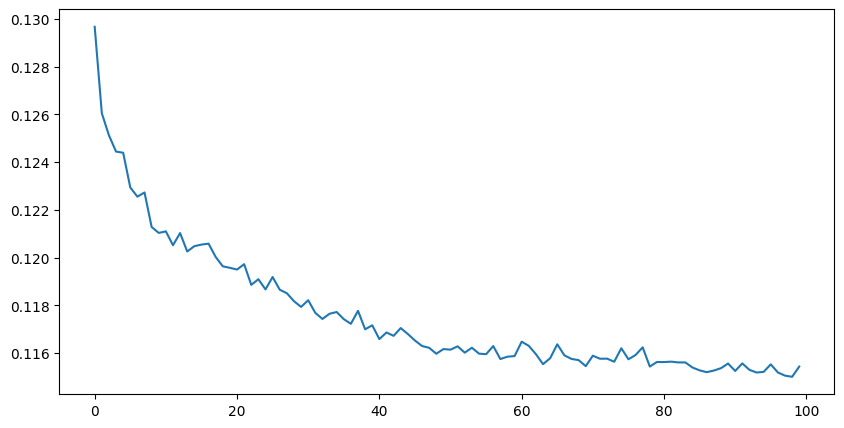

In [19]:
plt.figure(figsize=(10,5))
plt.plot(train_progress)
# plt.plot(test_progress)
plt.show()

In [21]:
with torch.no_grad():
    # shift train predictions for plotting
    y_pred_train = model(X_train)[:,-1,:]
    y_pred_test = model(X_test)[:,-1,:]

print(y_pred_train.shape, y_pred_test.shape, y_pred_test.shape[0] + y_pred_train.shape[0])

torch.Size([27202, 1]) torch.Size([6798, 1]) 34000


In [22]:
model(X_test).shape

torch.Size([6798, 4, 1])

In [23]:
y_pred = torch.cat([y_pred_train, y_pred_test], dim=0)
y_pred.shape

torch.Size([34000, 1])

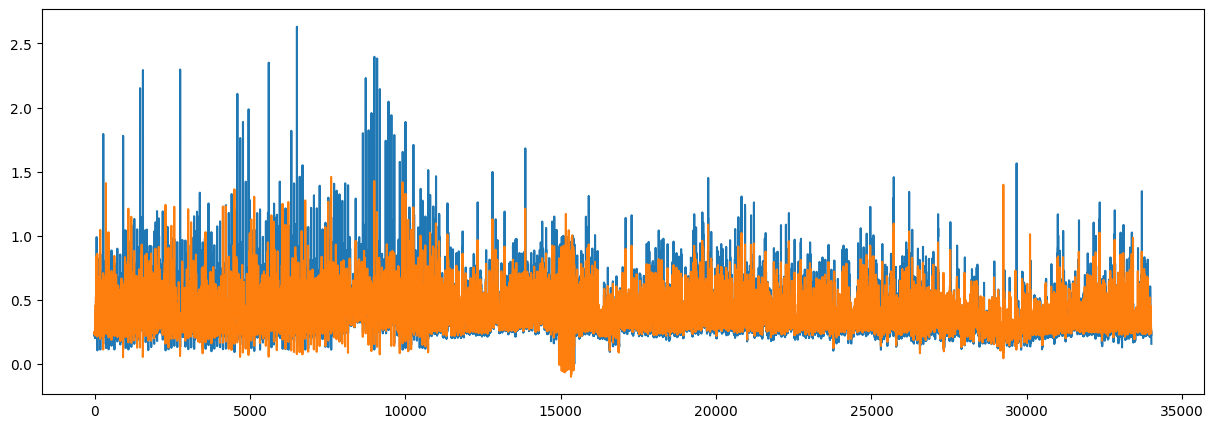

In [24]:
plt.figure(figsize=(15,5))

plt.plot(timeseries)
plt.plot(y_pred)

In [25]:
y_test = pd.read_csv('../data/test.csv')[['_value']]
y_train = pd.read_csv('../data/train.csv')[['_value']]

In [26]:
y_test = y_test[3:].values.tolist()

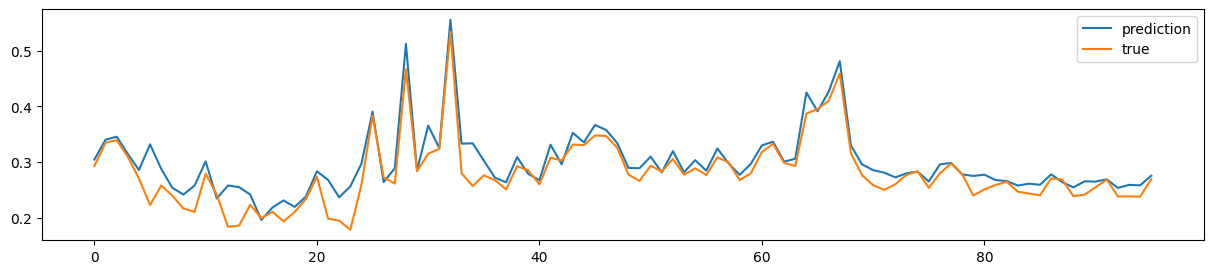

In [30]:
plt.figure(figsize=(15,3))
plt.plot(y_pred_test[:96], label='prediction')
plt.plot(y_test[:96], label='true')
plt.legend()
plt.show()

In [28]:
torch.save(model.state_dict(), '../saved_models/lstm_w4.pt')